Volume correspondant aux extrema
[0.53594527 2.95056537]
Pression correspondant aux extrema
[-2.54745543  0.26673645]
Racines de l'équation d'état pour P = 0.1
[ 0.43246046  1.61909074 14.28178213]
Aires A1 et A2
1.1025014065663874 0.9053293937434603


/tmp/ipykernel_313806/660392626.py:85: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A1 = integrate.quad(func_Area_left, roots_V[0], roots_V[1], args=(T, P))[0]


ValueError: f(a) and f(b) must have different signs

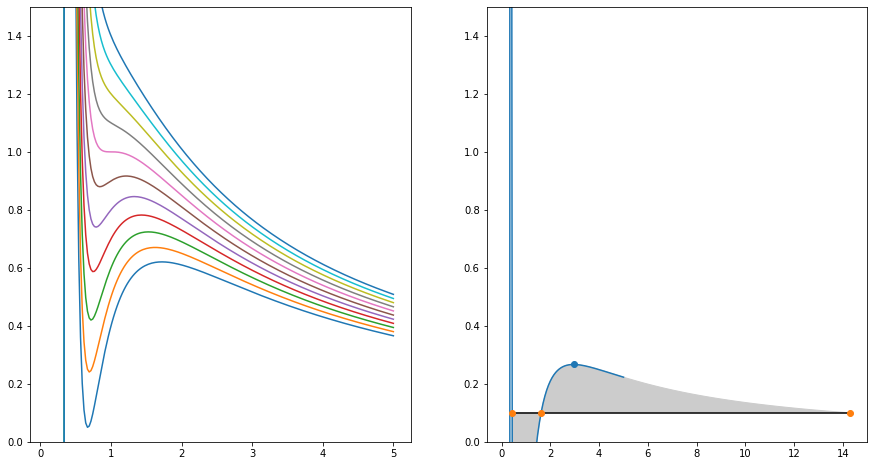

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate
import numpy.polynomial.polynomial as poly

"""
Construction des isothermes pour un gaz de Van der Waals, construction de Maxwell

Le but du script est de trouver la pression pour laquelle il y a coexistence du liquide et du gaz 
en dessous de la température critique.

"""


def isotherme_Andrews(V, T):
    """
    expression de la pression en fonction du volume  réduit V et de la température réduite T
    """
    # return (8*T*V**2-9*V+3)/(3*V**3-V**2)
    return 8 / 3 * T / (V - 1 / 3) - 3 / V**2


def annul_derPvsV(T):  # Question 2
    """Racine du polynôme correspondant à l'annulation de la dérivée,
    on donne les deux racines les plus grandes qui sont les seules
    à nous intéresser

    Le calcul de la dérivée et la recherche de zéro amène au fait que les annulation de la dérivée correspond
    au fait de trouver les racines du polynôme

    2-12V+18V**2-8TV**3

    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [2, -12, 18, -8 * T]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines, on exclue la première racine qui ne nous intéresse pas
    return np.sort(pol.roots())[1:]


def find_roots_V(P, T):
    """
    Racine V du polynôme P(V;T)
    on part de l'équation d'état
    3P V^3-(P+8T)V^2+9V-3
    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [-3, 9, -(P + 8 * T), 3 * P]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines par ordre croissant
    return np.sort(pol.roots())


def func_Area_left(V, T, P):
    """
    Valeur de la fonction à intégrer entre les deux premières racines
    """
    return P - isotherme_Andrews(V, T)


def func_Area_right(V, T, P):
    """
    Valeur de la fonction à intégrer entre les deux dernières racines
    """
    return isotherme_Andrews(V, T) - P


def equal_areas(P, T):
    """
    Fonction pour trouver l'égalité des aires
    A1 est l'aire de la partie gauche (intégration de func_Area_left)
    A2 est l'aire de la partie droite (intégration de func_Area_right)
    """
    # On trouve les racines entre lesquelles faire l'intégration
    roots_V = find_roots_V(P, T)
    # réalisation de l'intégration
    A1 = integrate.quad(func_Area_left, roots_V[0], roots_V[1], args=(T, P))[0]
    A2 = integrate.quad(func_Area_right, roots_V[1], roots_V[2], args=(T, P))[0]
    # On cherche l'égalité entre les aires
    return A1 - A2


# Programme principal
if __name__ == "__main__":
    # Températures et volumes étudiés
    Ts = np.linspace(0.85, 1.1, 11)
    Vs = np.linspace(0.5, 4, 200)

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    # Tracé des isothermes : question 1
    for T in Ts:
        ax1.plot(Vs, isotherme_Andrews(Vs, T))
    ax1.set_ylim(0, 1.5)

    # On fixe la témpérature
    T = 0.9
    # Question 2 Valeur des volumes qui annulent la dérivée
    V_extremum = annul_derPvsV(T)

    # Question 3 Valeur des extremums de la pression
    P_extremum = isotherme_Andrews(V_extremum, T)
    print("Volume correspondant aux extrema")
    print(V_extremum)
    print("Pression correspondant aux extrema")
    print(P_extremum)

    ax2 = fig.add_subplot(gs[0, 1])
    # tracé pour T=0.9
    ax2.plot(Vs, isotherme_Andrews(Vs, T))
    # tracé de la pression exremum
    ax2.scatter(V_extremum, P_extremum, zorder=20)
    ax2.set_ylim(0, 1.5)

    # On fixe la pressions
    P_e = 0.6
    # Question 4 valeur de V qui donnent P(V,T) = P_e
    roots_V = find_roots_V(P_e, T)
    ax2.scatter(roots_V, isotherme_Andrews(roots_V, T), zorder=20)
    print("Racines de l'équation d'état pour P = {}".format(P_e))
    print(roots_V)

    # tracé de la ligne horizontale
    ax2.hlines(P_e, np.min(roots_V), np.max(roots_V), color="black")

    # tracée de la zone grisée
    Vshade = np.linspace(roots_V[0], roots_V[2], 200)
    ax2.fill_between(Vshade, isotherme_Andrews(Vshade, T), P_e, color="#cccccc")

    ##Question 5 Calcul des deux aires
    A1 = integrate.quad(func_Area_left, roots_V[0], roots_V[1], args=(T, P_e))[0]
    A2 = integrate.quad(func_Area_right, roots_V[1], roots_V[2], args=(T, P_e))[0]
    print("Aires A1 et A2")
    print(A1, A2)

    # Ici, on prend un tout petit peu à l'intérieur des extrema de P
    # pour éviter d'avoir des racines complexes pour le polynôme aux extrema
    P_iso = optimize.brentq(
        equal_areas, P_extremum[0] + 1e-3, P_extremum[1] - 1e-3, args=(T)
    )
    print(
        "Pression à l'équilibre liquide/gaz pour une température réduite T_R = {}".format(
            T
        )
    )
    print(P_iso)

    plt.savefig("VdW.svg")
    plt.show()

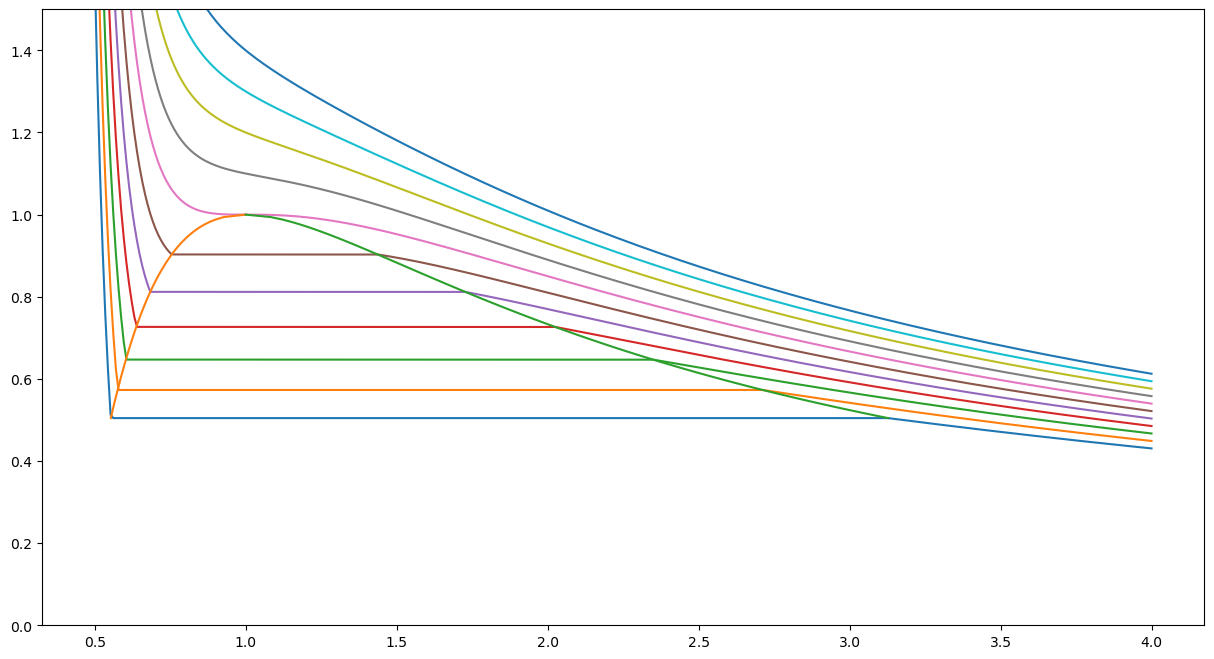

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate
import numpy.polynomial.polynomial as poly

"""
Construction des isothermes pour un gaz de Van der Waals, construction de Maxwell

Le but du script est de trouver la pression pour laquelle il y a coexistence du liquide et du gaz 
en dessous de la température critique.

"""


def isotherme_Andrews(V, T):
    """
    expression de la pression en fonction du volume  réduit V et de la température réduite T
    """
    # return (8*T*V**2-9*V+3)/(3*V**3-V**2)
    return 8 / 3 * T / (V - 1 / 3) - 3 / V**2


def annul_derPvsV(T):  # Question 2
    """Racine du polynôme correspondant à l'annulation de la dérivée,
    on donne les deux racines les plus grandes qui sont les seules
    à nous intéresser

    Le calcul de la dérivée et la recherche de zéro amène au fait que les annulation de la dérivée correspond
    au fait de trouver les racines du polynôme

    2-12V+18V**2-8TV**3

    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [2, -12, 18, -8 * T]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines, on exclue la première racine qui ne nous intéresse pas
    return np.sort(pol.roots())[1:]


def find_roots_V(P, T):
    """
    Racine V du polynôme P(V;T)
    on part de l'équation d'état
    3P V^3-(P+8T)V^2+9V-3
    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [-3, 9, -(P + 8 * T), 3 * P]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines par ordre croissant
    return np.sort(pol.roots())


def func_Area_left(V, T, P):
    """
    Valeur de la fonction à intégrer entre les deux premières racines
    """
    return P - isotherme_Andrews(V, T)


def func_Area_right(V, T, P):
    """
    Valeur de la fonction à intégrer entre les deux dernières racines
    """
    return isotherme_Andrews(V, T) - P


def equal_areas(P, T):
    """
    Fonction pour trouver l'égalité des aires
    A1 est l'aire de la partie gauche (intégration de func_Area_left)
    A2 est l'aire de la partie droite (intégration de func_Area_right)
    """
    # On trouve les racines entre lesquelles faire l'intégration
    roots_V = find_roots_V(P, T)
    # réalisation de l'intégration
    A1 = integrate.quad(func_Area_left, roots_V[0], roots_V[1], args=(T, P))[0]
    A2 = integrate.quad(func_Area_right, roots_V[1], roots_V[2], args=(T, P))[0]
    # On cherche l'égalité entre les aires
    return A1 - A2


def isotherme_Andrews_full(V, T):
    """
    expression de la pression en fonction du volume V et de la température T
    """

    # En dessous de la température critique, il faut faire la construction de Maxwell
    if T < 1:
        V_extremum = annul_derPvsV(T)
        P_extremum = isotherme_Andrews(V_extremum, T)
        # On a besoin des extremums pour les bornes à donner pour l'optimisation
        P_iso = optimize.brentq(
            equal_areas, P_extremum[0] + 1e-3, P_extremum[1] - 1e-3, args=(T)
        )
        roots_V = find_roots_V(P_iso, T)

        # On met par défaut la valeur de la pression lors de la coexistence de phase
        Ps = np.ones_like(V) * P_iso
        # Pression pour le liquide
        Ps[V < roots_V[0]] = isotherme_Andrews(V[V < roots_V[0]], T)
        # Pression pour le gaz
        Ps[V > roots_V[2]] = isotherme_Andrews(V[V > roots_V[2]], T)
        return Ps
    # Sinon, l'équation d'état est valide partout
    else:
        return isotherme_Andrews(V, T)


def critical_curve(Ts):
    """
    Courbe donnant P_iso=f(V) pour différente valeurs de T
    """

    Ps = []
    V0 = []
    V2 = []
    for T in Ts:
        # print(T)
        V_extremum = annul_derPvsV(T)
        P_extremum = isotherme_Andrews(V_extremum, T)
        # On a besoin des extremums pour les bornes à donner pour l'optimisation
        P_iso = optimize.brentq(
            equal_areas, P_extremum[0] + 1e-3, P_extremum[1] - 1e-3, args=(T)
        )
        roots_V = find_roots_V(P_iso, T)
        Ps.append(P_iso)
        V0.append(roots_V[0])
        V2.append(roots_V[2])
    return Ps, V0, V2


# Programme principal
if __name__ == "__main__":
    Ts = np.linspace(0.85, 1.1, 11)
    Vs = np.linspace(0.5, 4, 400)

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    for T in Ts:
        ax1.plot(Vs, isotherme_Andrews_full(Vs, T))
    ax1.set_ylim(0, 1.5)

    # Tracé de la courbe critique
    Ts = np.linspace(0.85, 1, 100)
    Ps, V0, V2 = critical_curve(Ts)
    plt.plot(V0, Ps)
    plt.plot(V2, Ps)

    plt.savefig("VdW2.svg")
    plt.show()

-1.6845325446098385 0.67
[-1.85786289  0.56102217  0.56954352]
0.34366974321868576 0.67
[0.45246349 2.39917235 2.68048703]


/tmp/ipykernel_313806/1205291479.py:79: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Area = integrate.quad(func_Area, roots_V[0], roots_V[2], args=(T, P))[0]


ValueError: f(a) and f(b) must have different signs

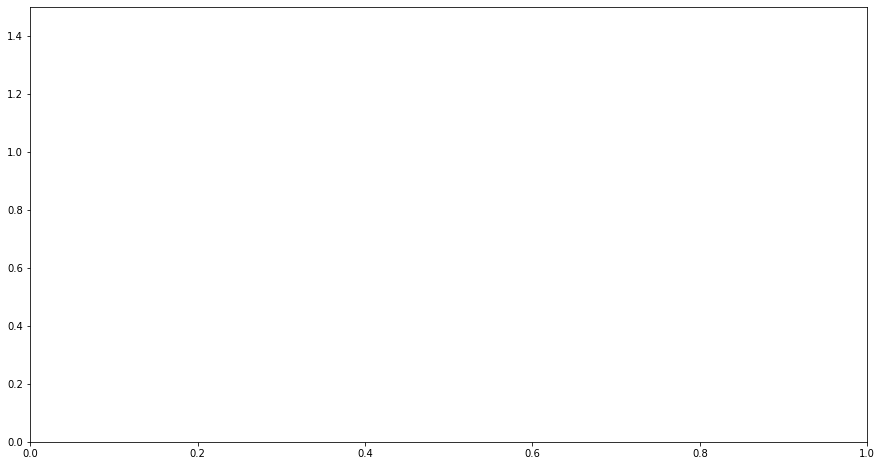

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate
import numpy.polynomial.polynomial as poly

"""
Construction des isothermes pour un gaz de Van der Waals, construction de Maxwell

Le but du script est de trouver la pression pour laquelle il y a coexistence du liquide et du gaz 
en dessous de la température critique.

"""


def isotherme_Andrews(V, T):
    """
    expression de la pression en fonction du volume  réduit V et de la température réduite T
    """
    # return (8*T*V**2-9*V+3)/(3*V**3-V**2)
    return 8 / 3 * T / (V - 1 / 3) - 3 / V**2


def annul_derPvsV(T):  # Question 2
    """Racine du polynôme correspondant à l'annulation de la dérivée,
    on donne les deux racines les plus grandes qui sont les seules
    à nous intéresser

    Le calcul de la dérivée et la recherche de zéro amène au fait que les annulation de la dérivée correspond
    au fait de trouver les racines du polynôme

    2-12V+18V**2-8TV**3

    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [2, -12, 18, -8 * T]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines, on exclue la première racine qui ne nous intéresse pas
    return np.sort(pol.roots())[1:]


def find_roots_V(P, T):
    """
    Racine V du polynôme P(V;T)
    on part de l'équation d'état
    3P V^3-(P+8T)V^2+9V-3
    """
    # coefficients issus de l'annulation de la dérivée de P puis ramené sous forme de polynome
    coeffs = [-3, 9, -(P + 8 * T), 3 * P]
    # définition du polynome
    pol = poly.Polynomial(coeffs)
    # calcule des racines par ordre croissant
    return np.sort(pol.roots())


def func_Area(V, T, P):
    return P - isotherme_Andrews(V, T)


def equal_areas(P, T):
    """
    Fonction pour trouver l'égalité des aires
    Area est l'aire entre l'isotherme et la pression
    """
    # On trouve les racines entre lesquelles faire l'intégration
    roots_V = find_roots_V(P, T)
    print(P, T)
    print(roots_V)
    # réalisation de l'intégration
    Area = integrate.quad(func_Area, roots_V[0], roots_V[2], args=(T, P))[0]
    return Area


def isotherme_Andrews_full(V, T):
    """
    expression de la pression en fonction du volume V et de la température T
    """

    # En dessous de la température critique, il faut faire la construction de Maxwell
    if T < 1:
        V_extremum = annul_derPvsV(T)
        P_extremum = isotherme_Andrews(V_extremum, T)
        # On a besoin des extremums pour les bornes à donner pour l'optimisation
        P_iso = optimize.brentq(
            equal_areas, P_extremum[0] + 1e-3, P_extremum[1] - 1e-3, args=(T)
        )
        roots_V = find_roots_V(P_iso, T)

        # On met par défaut la valeur de la pression lors de la coexistence de phase
        Ps = np.ones_like(V) * P_iso
        # Pression pour le liquide
        Ps[V < roots_V[0]] = isotherme_Andrews(V[V < roots_V[0]], T)
        # Pression pour le gaz
        Ps[V > roots_V[2]] = isotherme_Andrews(V[V > roots_V[2]], T)
        return Ps
    # Sinon, l'équation d'état est valide partout
    else:
        return isotherme_Andrews(V, T)


def critical_curve(Ts):
    """
    Courbe donnant P_iso=f(V) pour différente valeurs de T
    """

    Ps = []
    V0 = []
    V2 = []
    for T in Ts:
        # print(T)
        V_extremum = annul_derPvsV(T)
        P_extremum = isotherme_Andrews(V_extremum, T)
        # On a besoin des extremums pour les bornes à donner pour l'optimisation
        P_iso = optimize.brentq(
            equal_areas, P_extremum[0] + 1e-3, P_extremum[1] - 1e-3, args=(T)
        )
        roots_V = find_roots_V(P_iso, T)
        Ps.append(P_iso)
        V0.append(roots_V[0])
        V2.append(roots_V[2])
    return Ps, V0, V2


# Programme principal
if __name__ == "__main__":
    Ts = np.linspace(0.85, 1.1, 11)
    Vs = np.linspace(0.5, 4, 400)

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    # for T in Ts:
    #    ax1.plot(Vs, isotherme_Andrews_full(Vs, T))
    ax1.set_ylim(0, 1.5)

    # Tracé de la courbe critique
    Ts = np.linspace(0.67, 1 - 1e-3, 100)
    Ps, V0, V2 = critical_curve(Ts)
    plt.plot(V0, Ps)
    plt.plot(V2, Ps)

    plt.savefig("VdW2.svg")
    plt.show()